## Dimensionality Reduction - Feature Space Reduction
### Principal Component Analysis (PCA)

PCA is a dimensionality reduction technique which aims to simplify the data representation by reducing the number of features.  It looks for underlying patterns or structures in the data and reduces features into fewer 'dimensions' or 'principal components'.  These components explain the variance in the data - the first component having the most, and each subsequent component explaining less but cumulatively more of the variance.  The components are orthogonal to each other, which means that they are independent - that is they are not correlated with each other.  This is useful as it reduces multicollinearity and addresses any redundancy.  

PCA in a nutshell: 

* Data transformed into new uncorrelated components by linear combination of original features
* First component explains the most variance in the data while being orthogonal to the other components
* Select a subset of the components - which *explain* enough of teh variance in the data for the purposes of the analysis.  Ths is the dimensionality reduction part.
* Looking at the component loadings can help to interpret what the components represent
* Fewer features allows for different visualisations of the data


I am applying PCA because I think the features are highly correlated and can be better represented by fewer features, without losing predictive power of a model.  It should be computationally more efficient, although we are not dealing with a large number of features here.  On the other hand, different analysis with all features (i.e. student demographic, biographic, etc.) could benefit from PCA.

### PCA on prepreocessed data

In [42]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# load csv files 
X_train_transformed = pd.read_csv('../../data/X_train_transformed.csv')
X_test_transformed = pd.read_csv('../../data/X_test_transformed.csv')
X_val_transformed = pd.read_csv('../../data/X_val_transformed.csv')
y_val = pd.read_csv('../../data/y_val.csv')
y_train = pd.read_csv('../../data/y_train.csv')
y_test = pd.read_csv('../../data/y_test.csv')

## data is already preprocessed, otherwise it would not be be preprocessed here

# PCA instance
pca = PCA(n_components=10)  # Adjust the number of components as desired

# fit the PCA model
pca.fit(X_train_transformed)

# apply PCA transformation to both training and test data
X_train_pca = pca.transform(X_train_transformed)
X_test_pca = pca.transform(X_test_transformed)
X_val_pca = pca.transform(X_val_transformed)






Looking at the explained variance ratio below, we can see that the first component explains 49% of the variance followed by 14%, 12%, 10%, 8%, 5%, 2%, 1.3%, 0.45 and 0.3% for the next 9 components

In [44]:
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)


Explained Variance Ratio: [0.48542779 0.13561634 0.11804524 0.09648109 0.07812855 0.04584478
 0.02059911 0.01314071 0.00391463 0.00280175]


The scree plot which visualises the explained variance shows a clear elbow at the second component.  This is traditionally the poitn where the number of components is selected.  

However, I am going to select the first 4 components as they explain 76% of the variance.  This is a trade-off between the number of components and the amount of variance explained.  

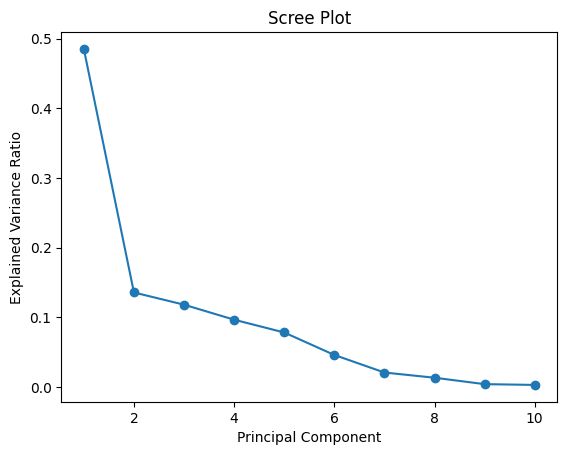

In [45]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()


Another method for determining the number of components to retain is by selecting those with an eigenvalue of 1 or greater which is the Kaiser criterion.  In this case, the first 3 components have an eigenvalue of 1 or greater with the fourth component just below at 0.9.

In [46]:
eigenvalues = pca.explained_variance_
print("Eigenvalues:", eigenvalues)


Eigenvalues: [4.59032686 1.28242212 1.11626535 0.91234935 0.73880311 0.43351972
 0.19479036 0.12426188 0.03701773 0.02649408]


#### Visualising the components

Below is a scatter plot of the first two components, with data points coloured by the target variable - final_result.  It is not so nice - trying seaborn next.

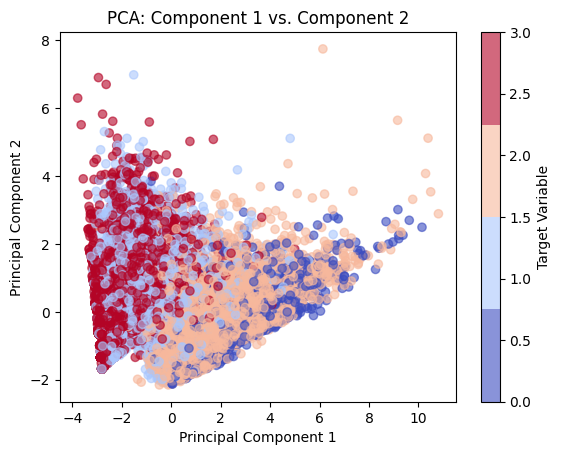

In [47]:
import numpy as np

component_1 = 0  
component_2 = 1  

# target variable values
target_values = y_train['final_result'].astype('category')

# color codes based on categorical codes
color_codes = target_values.cat.codes

# unique color values
unique_colors = np.unique(color_codes)

# colormap based on the number of unique colors
cmap = plt.cm.get_cmap('coolwarm', len(unique_colors))

plt.scatter(X_train_pca[:, component_1], X_train_pca[:, component_2], c=color_codes, cmap=cmap, alpha=0.6)
plt.xlabel(f"Principal Component {component_1 + 1}")
plt.ylabel(f"Principal Component {component_2 + 1}")
plt.title("PCA: Component 1 vs. Component 2")
plt.colorbar(label="Target Variable")
plt.show()




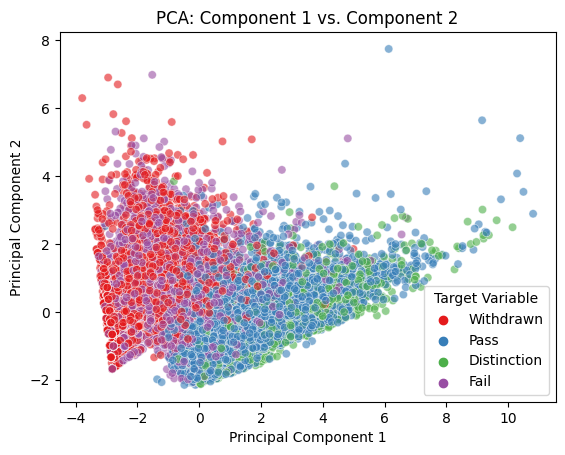

In [48]:
import seaborn as sns

component_1 = 0  
component_2 = 1  

# combine X_train_pca and y_train 
df = pd.DataFrame(X_train_pca, columns=[f"Component {i+1}" for i in range(X_train_pca.shape[1])])
df['Target Variable'] = y_train['final_result']

sns.scatterplot(data=df, x=f"Component {component_1+1}", y=f"Component {component_2+1}", hue='Target Variable', palette='Set1', alpha=0.6)
plt.xlabel(f"Principal Component {component_1 + 1}")
plt.ylabel(f"Principal Component {component_2 + 1}")
plt.title("PCA: Component 1 vs. Component 2")
plt.show()


The seaborn plot is nicer.  We can see that the first component separates the data between those who `fail / withdraw` and those who `pass / distinction`.  This makes me reconsider whether the outcome should be refactored and the analysis should be binary classification on 'intervention required?' instead of four separate outcomes.  This would be a more useful model for the university to identify students who need intervention.  However, I will continue with the four outcomes for now.

In [49]:
import pandas as pd

# Get the feature loadings for the first four components
n_components = 4
feature_loadings = pca.components_[:n_components, :]

# Create a DataFrame to store the feature loadings
loadings_df = pd.DataFrame(columns=['feature'] + [f'component {i+1}' for i in range(n_components)])

# Iterate over features and components to populate the DataFrame
for feature_idx, feature_name in enumerate(X_train_transformed.columns):
    loadings_df.loc[feature_idx] = [feature_name] + list(feature_loadings[:, feature_idx])

# Display the feature loadings table
print(loadings_df)





                    feature  component 1  component 2  component 3  \
0            subject_SocSci    -0.037928    -0.163368     0.031209   
1              subject_Stem     0.037928     0.163368    -0.031209   
2      num_of_prev_attempts    -0.057983     0.392136     0.495239   
3           studied_credits    -0.055011     0.474696     0.550662   
4          prop_submissions     0.393813    -0.230167     0.086270   
5                 avg_score     0.401698    -0.234611     0.086350   
6       submission_distance    -0.095172     0.564874    -0.605491   
7        stu_activity_count     0.429719     0.154334     0.019341   
8   stu_activity_type_count     0.363727     0.275394    -0.256955   
9          stu_total_clicks     0.398305     0.185416     0.007193   
10          stu_days_active     0.435459     0.079833     0.039897   

    component 4  
0      0.137632  
1     -0.137632  
2      0.648155  
3     -0.323635  
4      0.335590  
5      0.298353  
6      0.244981  
7     -0.222606

* `Component 1`: 
  * loads highly and positively on 'proportion_submission', 'average_score', 'stu_activity_count', 'stu_activity_type_count', and 'stu_total_clicks' - these are all related to student engagement
  
* `Component 2`:
  * loads highly and positively on 'num_of_prev_attempts', 'studied_credits' and `submission_distance' - these are related to the student's academic history and submission behaviour.


#### Save to csv - 4 components

In [50]:
# load csv files 
X_train_transformed = pd.read_csv('../../data/X_train_transformed.csv')
X_test_transformed = pd.read_csv('../../data/X_test_transformed.csv')
X_val_transformed = pd.read_csv('../../data/X_val_transformed.csv')
y_train = pd.read_csv('../../data/y_train.csv')
y_test = pd.read_csv('../../data/y_test.csv')
y_val = pd.read_csv('../../data/y_val.csv')

## data is already preprocessed, otherwise it would not be be preprocessed here

# PCA instance
pca = PCA(n_components=4)  # Adjust the number of components as desired

# fit the PCA model
pca.fit(X_train_transformed)

# apply PCA transformation to both training and test data
X_train_pca = pca.transform(X_train_transformed)
X_test_pca = pca.transform(X_test_transformed)
X_val_pca = pca.transform(X_val_transformed)

# save the transformed data
pd.DataFrame(X_train_pca).to_csv('../../data/X_train_pca.csv', index=False)
pd.DataFrame(X_test_pca).to_csv('../../data/X_test_pca.csv', index=False)
pd.DataFrame(X_val_pca).to_csv('../../data/X_val_pca.csv', index=False)

#### preprocess function from 04_01_model_prep.ipynb

In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def preprocess_data(data):
    # columns to be used for each type of variable
    numeric_columns = ['num_of_prev_attempts', 'studied_credits', 'prop_submissions', 'avg_score', 'submission_distance', 'stu_activity_count', 'stu_activity_type_count', 'stu_total_clicks', 'stu_days_active']
    nominal_columns = ['subject']

    # check required columns exist
    missing_numeric_cols = [col for col in numeric_columns if col not in data.columns]
    missing_nominal_cols = [col for col in nominal_columns if col not in data.columns]

    assert not missing_numeric_cols, f"Missing numeric columns: {', '.join(missing_numeric_cols)}"
    assert not missing_nominal_cols, f"Missing nominal columns: {', '.join(missing_nominal_cols)}"

    # drop unneeded columns
    unneeded_cols = [col for col in data.columns if col not in numeric_columns + nominal_columns]
    data = data.drop(unneeded_cols, axis=1)

    # preprocessing for each type of variable
    numeric_transformer = StandardScaler()
    nominal_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')

    # ColumnTransformer for appropriate transformations
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numeric_transformer, numeric_columns),
            ('nominal', nominal_transformer, nominal_columns)
        ])

    # fit and transform the data
    transformed_data = preprocessor.fit_transform(data)

    return transformed_data


# Example usage
data = pd.read_csv('data.csv')  # Load your dataset here
preprocessed_data = preprocess_data(data)


#### PCA function

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

def pca_pipeline(preprocessed_data, n_components=4):
    
    # PCA pipeline
    pca_pipeline = Pipeline([
        ('pca', PCA(n_components))  # number of components as desired
    ])

    # apply PCA transformation 
    transformed_data = pca_pipeline.fit_transform(preprocessed_data)

    return transformed_data

#### Combined processing and PCA function

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

def process_and_pca_pipeline(data, n_components=2):
    # preprocess the data
    processed_data = preprocess_data(data)

    # PCA pipeline
    pca_pipeline = Pipeline([
        ('pca', PCA(n_components))  # number of components as desired
    ])

    # apply PCA transformation 
    transformed_data = pca_pipeline.fit_transform(processed_data)

    return transformed_data
